### project3_6_randomforest_supportvector.ipynb,

wherein I try a couple more models.

In [60]:
#import my now pretty long list of libraries:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier




Load in my data and other dataframes as before:

In [61]:
df = pd.read_csv('./data/redditcomments.csv')
df.drop(columns='Unnamed: 0',inplace=True)
df.dropna(inplace=True)
df['char_length'] = [len(comment) for comment in list(df['comment'])]
df = df[(df['char_length']>=10) & (df['char_length']<1000)]
df.head()

,comment,date,types,char_length
0,I think it's the end of the first episode rath...,1615999558,fantasy,76
1,I think you mean the prologue of the Wheel of ...,1615999475,fantasy,87
2,"Not properly ""Fantasy"", but ""Horus Rising"" ope...",1615999395,fantasy,218
3,Love that trilogy. Bit slow to get started (af...,1615999383,fantasy,85
4,&gt;At this point I think Sanderson being the ...,1615999332,fantasy,566


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18746 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      18746 non-null  object
 1   date         18746 non-null  int64 
 2   types        18746 non-null  object
 3   char_length  18746 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 732.3+ KB


In [ ]:
comments = list(df['comment'])
df['flagged'] = [1 if ('removed' in comment.split(' ')) else 0 for comment in comments]
df = df[df['flagged']==0]

In [63]:
stops_df = pd.read_csv('./data/stopwords.csv')
stops = list(stops_df['0'])
stops

['thick',
 'beyond',
 'six',
 'hereafter',
 'both',
 'her',
 'am',
 'forty',
 'very',
 'its',
 'above',
 'ours',
 'who',
 'someone',
 'might',
 'whenever',
 'per',
 'un',
 'may',
 'cannot',
 'formerly',
 'before',
 'up',
 'of',
 'amongst',
 'couldnt',
 'more',
 'four',
 'it',
 'thereupon',
 'there',
 'again',
 'him',
 'beside',
 'they',
 'less',
 'us',
 'hasnt',
 'in',
 'while',
 'one',
 'seeming',
 'had',
 'several',
 'thereafter',
 'since',
 'ten',
 'for',
 'too',
 'been',
 'de',
 'etc',
 'herself',
 'wherein',
 'herein',
 'during',
 'such',
 'noone',
 'yours',
 'serious',
 'whether',
 'enough',
 'whoever',
 'cant',
 'must',
 'eg',
 'otherwise',
 'itself',
 'get',
 'them',
 'why',
 'few',
 'nobody',
 'rather',
 'between',
 'ourselves',
 'fill',
 'below',
 'are',
 'indeed',
 'mine',
 'still',
 'perhaps',
 'thence',
 'most',
 'others',
 'no',
 'go',
 'then',
 'inc',
 'have',
 'hers',
 'twenty',
 'this',
 'full',
 'me',
 'either',
 'side',
 'onto',
 'five',
 'latterly',
 'con',
 'except

In [64]:
predictions = pd.read_csv('./data/predictions.csv')
predictions.drop(columns = 'Unnamed: 0', inplace=True)
predictions.head()

,types,Simple NB,Simple LR,LR 5000 features
0,fantasy,fantasy,fantasy,fantasy
1,fantasy,fantasy,fantasy,fantasy
2,scifi,scifi,scifi,scifi
3,scifi,scifi,scifi,scifi
4,scifi,scifi,scifi,scifi


In [65]:
predicted_probabilities = pd.read_csv('./data/predicted_probabilities.csv')
predicted_probabilities.drop(columns = 'Unnamed: 0', inplace=True)
predicted_probabilities.head()

,types,prediction,err type,err label,probability
0,0,0,0,"fantasy, correct",2.081928e-01
1,0,0,0,"fantasy, correct",2.242084e-08
2,1,1,3,"scifi, correct",9.309696e-01
3,1,1,3,"scifi, correct",9.962833e-01
4,1,1,3,"scifi, correct",7.649797e-01


In [66]:
scores = pd.read_csv('./data/scores.csv')
scores.drop(columns='ndx',inplace=True)
scores

,model,train,test
0,Baseline,0.501809,0.501909
1,NBayesian,0.829448,0.779184
2,LogReg,0.940715,0.814949
3,LogReg 5000,0.894628,0.801085
4,"LR with Lasso, a=1",0.892867,0.789237
5,"LR with Lasso, a=10",0.977844,0.796527
6,"LR with Ridge a=1 (ran 0.1, 1, 10)",0.951472,0.806389
7,"knn, k=1, uniform",0.993139,0.610206
8,"knn, k=3, uniform",0.766795,0.607847
9,"knn, k=5, uniform",0.761221,0.618997


Make X & y, train test split, and vectorize using CountVectorizer (since it was a bit better than TfidVectorizer) - 

In [68]:
X = df['comment']
y = df['types']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)
cv = CountVectorizer(stop_words=stops)
cv.fit(X_train,y_train)
Xcvec_train = tv.transform(X_train)
Xcvec_test  = tv.transform(X_test)



Do a simple Random Forest, default params:

In [69]:
rf = RandomForestClassifier()
rf.fit(Xcvec_train,y_train)
rf_train = rf.score(Xcvec_train,y_train)
rf_test  = rf.score(Xcvec_test,y_test)
print(f'Train: {rf_train}, Test: {rf_test}')

Train: 0.9931389365351629, Test: 0.7765866209262435


Pretty impressively overfit on train, still not beating log reg for test.

Now for some tuning:

In [71]:
param_grid = {
    'max_depth': [10, 100, 1000],
    'min_samples_split': [10, 100, 1000]
}

# define grid search
rf = RandomForestClassifier()
gs = GridSearchCV(rf, param_grid=param_grid, cv=5, verbose = 2)


In [72]:
gs.fit(Xcvec_train,y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=10, min_samples_split=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... max_depth=10, min_samples_split=10, total=   2.6s
[CV] max_depth=10, min_samples_split=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ............... max_depth=10, min_samples_split=10, total=   2.1s
[CV] max_depth=10, min_samples_split=10 ..............................
[CV] ............... max_depth=10, min_samples_split=10, total=   2.1s
[CV] max_depth=10, min_samples_split=10 ..............................
[CV] ............... max_depth=10, min_samples_split=10, total=   2.2s
[CV] max_depth=10, min_samples_split=10 ..............................
[CV] ............... max_depth=10, min_samples_split=10, total=   2.2s
[CV] max_depth=10, min_samples_split=100 .............................
[CV] .............. max_depth=10, min_samples_split=100, total=   2.1s
[CV] max_depth=10, min_samples_split=100 .............................
[CV] .............. max_depth=10, min_samples_split=100, total=   2.1s
[CV] max_depth=10, min_samples_split=100 .............................
[CV] .............. max_depth=10, min_samples_split=100, total=   2.6s
[CV] max_depth=10, min_samples_split=100 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 13.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 100, 1000],
                         'min_samples_split': [10, 100, 1000]},
             verbose=2)

In [73]:
gs.best_params_

{'max_depth': 1000, 'min_samples_split': 10}

In [74]:
gs.best_score_



0.776086093241204

In [75]:
print(f'Score on training set: {gs.score(Xcvec_train,y_train)}')
print(f'Score on testing set: {gs.score(Xcvec_test,y_test)}')

Score on training set: 0.98363350485992
Score on testing set: 0.7761578044596913


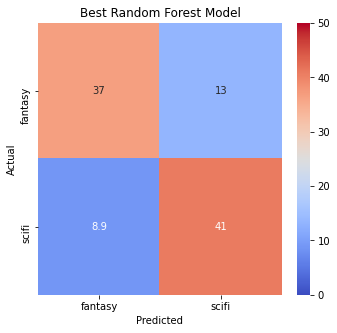

In [76]:
subreddits = ['fantasy', 'scifi']
fig = plt.figure(figsize=(12,5));
ax = fig.add_subplot(121);
preds_rf = gs.predict(Xcvec_test)
cm = confusion_matrix(y_test, preds_rf)
cm = cm*100/sum(sum(cm));
sns.heatmap(cm,ax=ax,annot=True, vmin = 0, vmax = 50, cmap='coolwarm');
ax.set_xticklabels(subreddits);
ax.set_yticklabels(subreddits);
plt.xlabel('Predicted');
plt.ylabel('Actual');
plt.title('Best Random Forest Model');



Still not an improvement. Plus, Random Forests don't have the interpretability of log reg, and I need that to answer my problem statement. But I did just want to see if I could get it really accurate.

Support Vector model:

In [29]:
svc = SVC(
    C = 1000,
    kernel = 'rbf', 
    gamma = 'scale'
)

# Fit on training data.
svc.fit(Xcvec_train, y_train)



NameError: name 'accuracy_score' is not defined

In [32]:
# Evaluate model.
svc_train = accuracy_score(y_train, svc.predict(Xcvec_train))
svc_test = accuracy_score(y_test, svc.predict(Xcvec_test))
print(f'Train: {svc_train}, Test: {svc_test}')

Train: 0.9933533447684391, Test: 0.8096054888507719


Almost as good as the log reg, but another massively overfit model.

Notes on Decision Trees vs. Random Forests:

A decision tree is built on an entire dataset, using all the features/variables of interest, whereas a random forest randomly selects observations/rows and specific features/variables to build multiple decision trees from and then averages the results.

https://www.google.com/search?client=safari&rls=en&q=difference+between+decision+tree+and+random+forest&ie=UTF-8&oe=UTF-8

### Last notebook left:

* project3_7: Enough modeling, time to visualize.




